In [1]:
import torch
from lightning.pytorch.callbacks import ModelCheckpoint, RichModelSummary

from rl4co.envs import SDVRPEnv
from rl4co.models.zoo import AttentionModel
from rl4co.utils.trainer import RL4COTrainer

/home/ethan/miniconda3/envs/llm4co/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/ethan/miniconda3/envs/llm4co/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# RL4CO env based on TorchRL
env = SDVRPEnv(generator_params=dict(num_loc=20))

# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env,
                       baseline='rollout',
                       train_data_size=100_000, # really small size for demo
                       val_data_size=10_000)

/home/ethan/miniconda3/envs/llm4co/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/ethan/miniconda3/envs/llm4co/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


Tour lengths: ['4.31', '5.03', '6.32']
Solution 1 is valid
Solution 2 is valid
Solution 3 is valid


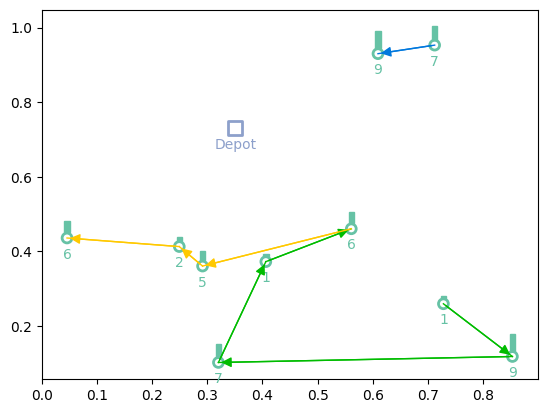

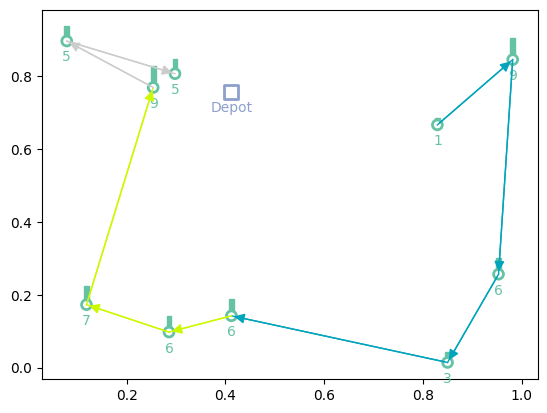

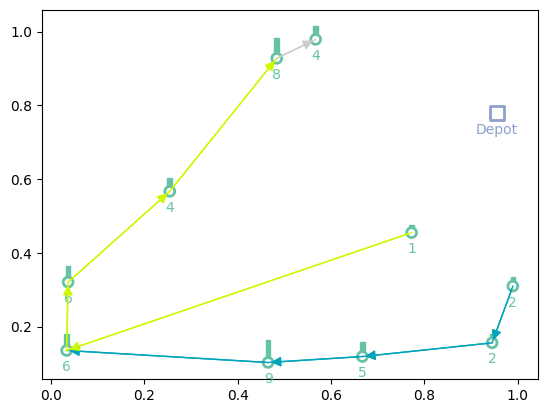

In [18]:
# Greedy rollouts over untrained policy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
policy = model.policy.to(device)
out = policy(td_init.clone(), env, phase="test", decode_type="greedy")

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for i, (td, actions) in enumerate(zip(td_init, out['actions'].cpu())):
    env.render(td, actions)
    # Fix: The check_solution_validity expects batch dimensions, so we need to add them back
    # Create a batch of size 1 for the individual solution
    td_batch = td.unsqueeze(0) if td.batch_size == () else td
    actions_batch = actions.unsqueeze(0) if actions.dim() == 1 else actions
    try:
        env.check_solution_validity(td_batch, actions_batch)
        print(f"Solution {i+1} is valid")
    except Exception as e:
        print(f"Solution {i+1} validation failed: {e}")

In [6]:
# Checkpointing callback: save models when validation reward improves
checkpoint_callback = ModelCheckpoint(  dirpath="checkpoints", # save to checkpoints/
                                        filename="epoch_{epoch:03d}",  # save as epoch_XXX.ckpt
                                        save_top_k=1, # save only the best model
                                        save_last=True, # save the last model
                                        monitor="val/reward", # monitor validation reward
                                        mode="max") # maximize validation reward

# Print model summary
rich_model_summary = RichModelSummary(max_depth=3)

# Callbacks list
callbacks = [checkpoint_callback, rich_model_summary]

In [8]:
from rl4co.utils.trainer import RL4COTrainer

logger = None
trainer = RL4COTrainer(
    max_epochs=2,
    accelerator="gpu",
    devices=1,
    logger=logger,
    callbacks=callbacks,
)

Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ethan/miniconda3/envs/llm4co/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [9]:
trainer.fit(model)

val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃    ┃ Name                                   ┃ Type                  ┃ Params ┃ Mode  ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0  │ env                                    │ SDVRPEnv              │      0 │ train │
│ 1  │ policy                                 │ AttentionModelPolicy  │  694 K │ train │
│ 2  │ policy.encoder                         │ AttentionModelEncoder │  595 K │ train │
│ 3  │ policy.encoder.init_embedding          │ VRPInitEmbedding      │    896 │ train │
│ 4  │ policy.encoder.net                     │ GraphAttentionNetwork │  594 K │ train │
│ 5  │ policy.decoder                         │ AttentionModelDecoder │ 98.8 K │ train │
│ 6  │ policy.decoder.context_embedding       │ VRPContext            │ 16.5 K │ train │
│ 7  │ policy.decoder.dynamic_embedding       │ SDVRPDynamicEmbedding │    384 │ train │
│ 8  │ policy.decoder.pointer                 │ PointerAttention      │ 16.4 K │ train │
│ 9  │ policy.decoder.project_node_embeddings │ Linear                │ 49.2 K │ train │
│ 10 │ policy.decoder.project_fixed_context   │ Linear                │ 16.4 K │ train │
│ 11 │ baseline                               │ WarmupBaseline        │  694 K │ train │
│ 12 │ baseline.baseline                      │ RolloutBaseline       │  694 K │ train │
│ 13 │ baseline.baseline.policy               │ AttentionModelPolicy  │  694 K │ eval  │
│ 14 │ baseline.warmup_baseline               │ ExponentialBaseline   │      0 │ train │
└────┴────────────────────────────────────────┴───────────────────────┴────────┴───────┘

Trainable params: 1.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 74                                                                                          
Modules in eval mode: 70

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s]

/home/ethan/miniconda3/envs/llm4co/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


/home/ethan/miniconda3/envs/llm4co/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 196/196 [00:07<00:00, 24.50it/s, v_num=18, train/reward=-7.57, train/loss=1.860]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 196/196 [00:08<00:00, 24.15it/s, v_num=18, train/reward=-7.57, train/loss=-0.478, val/reward=-7.42] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 196/196 [00:08<00:00, 22.68it/s, v_num=18, train/reward=-7.57, train/loss=-0.478, val/reward=-7.21]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 196/196 [00:09<00:00, 20.46it/s, v_num=18, train/reward=-7.57, train/loss=-0.478, val/reward=-7.21]


Tour lengths: ['8.05', '7.43', '7.62']


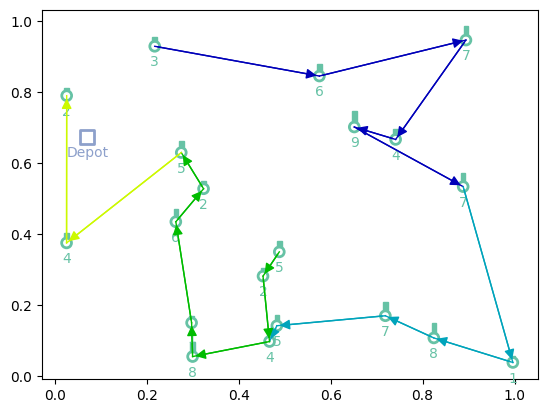

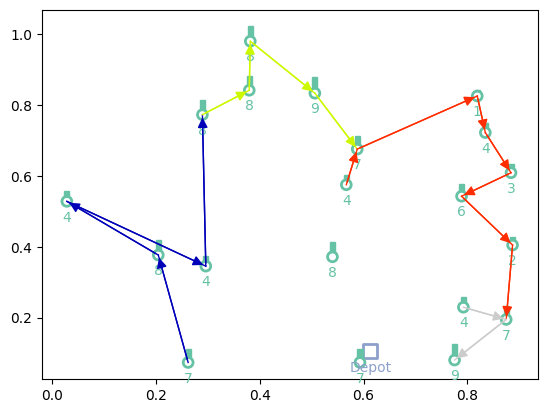

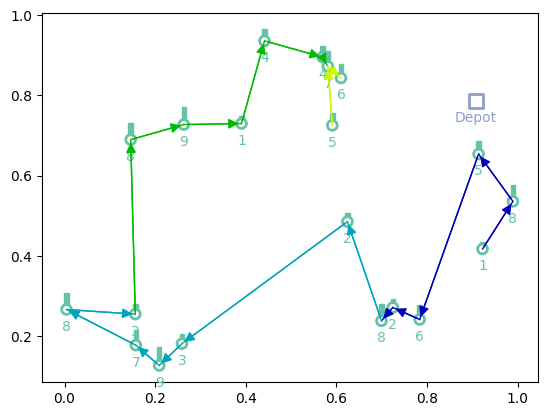

In [10]:
# Greedy rollouts over trained model (same states as previous plot)
policy = model.policy.to(device)
out = policy(td_init.clone(), env, phase="test", decode_type="greedy")

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)

In [11]:
trainer.test(model)

val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ethan/miniconda3/envs/llm4co/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 48.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/reward        │    -7.204610347747803     │
└───────────────────────────┴───────────────────────────┘

[{'test/reward': -7.204610347747803}]

In [15]:
# Test generalization to 50 nodes (not going to be great due to few epochs, but hey)
env = SDVRPEnv(generator_params=dict(num_loc=10))

# Generate data (100) and set as test dataset
new_dataset = env.dataset(50)
dataloader = model._dataloader(new_dataset, batch_size=100)

Tour lengths: ['6.30', '7.50', '5.64']


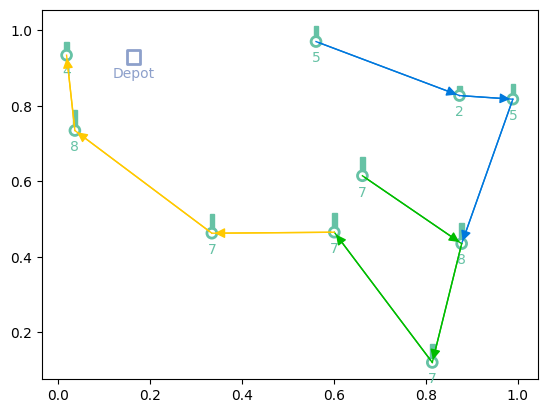

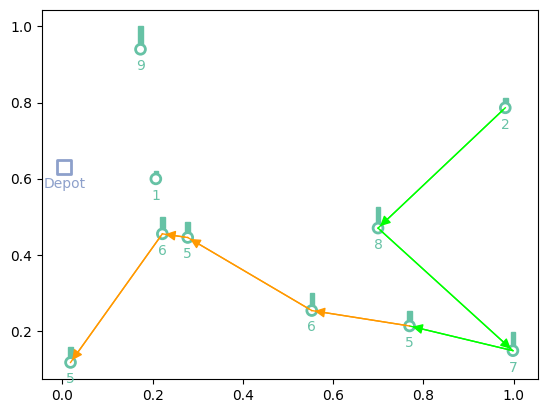

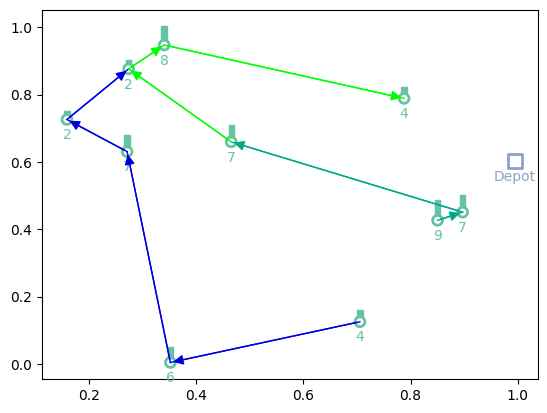

In [16]:
# Greedy rollouts over trained policy (same states as previous plot, with 20 nodes)
init_states = next(iter(dataloader))[:3]
td_init_generalization = env.reset(init_states).to(device)

policy = model.policy.to(device)
out = policy(td_init_generalization.clone(), env, phase="test", decode_type="greedy")

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init_generalization, out['actions'].cpu()):
    env.render(td, actions)